# Generating Chirp

In [52]:
import math
import cmath
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm
from sklearn.metrics import ConfusionMatrixDisplay
import pickle

In [53]:
def polynomialPhase(coeffs:list,t:int)->int:
    """
    Generate the polynomial phase 
    """
    total = 0
    for i in range(1,len(coeffs)+1):
        total += coeffs[i-1]*(t**i/math.factorial(i))
    return total

In [54]:
def chirp(coeffs:list,nS:int,f:int)->list:
    """
    Generate a sample chirp given coeffs, number of samples and frequency 
    """
    outer = []
    for n in range (0,nS):
        temp = cmath.exp(2j*math.pi*(polynomialPhase(coeffs,n/f)))
        outer.append(temp)
    return outer

In [55]:
nSamples = 10000
samplingFrequency = 2000
def plot_chirp(coeffs:list)->list:
    p = chirp(coeffs,nSamples,samplingFrequency)
    points = [i.real for i in p]
    plt.plot(points)
    return p

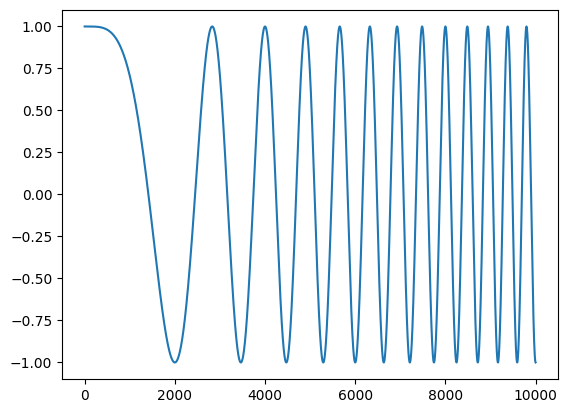

In [56]:
p = plot_chirp([0,1])

# Generating White Noise

In [57]:
def complexWhiteNoise(nS:int)->list:
    realDist = np.random.normal(0,1/math.sqrt(2),nS)
    imgDist = np.random.normal(0,1/math.sqrt(2),nS)
    return realDist + imgDist*1j

In [58]:
snr = 10
whiteNoisePoints = complexWhiteNoise(nSamples)/(10**(snr/20))
noisyPoints = p + whiteNoisePoints

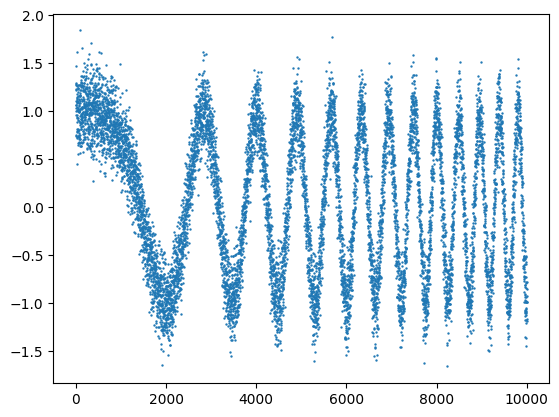

In [59]:
plt.scatter(range(0,len(noisyPoints)),noisyPoints.real,s=0.5)

# Normalizing 

In [60]:
def normalize(v:list)->list:
    return v / np.linalg.norm(v)

In [61]:
def normalizedMF(signal:list,template:list)->list:
    return np.correlate(normalize(signal),normalize(template),mode="full")

In [62]:
plot_n = normalizedMF(np.array(noisyPoints),np.array(p))

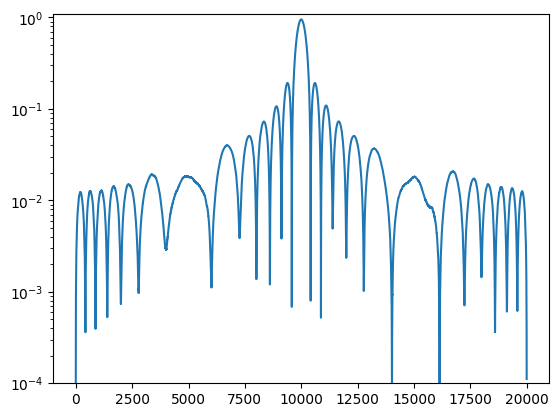

In [63]:
plt.plot([abs(i) for i in plot_n])
plt.yscale("log")
plt.ylim(10**-4, 1.1);

# Concatenate Matched Filter Outputs

In [64]:
def allAbsMFOutputs(signal:list,template:list)->list:
    outputs = [normalizedMF(signal,i) for i in template]
    return abs(np.concatenate(outputs))

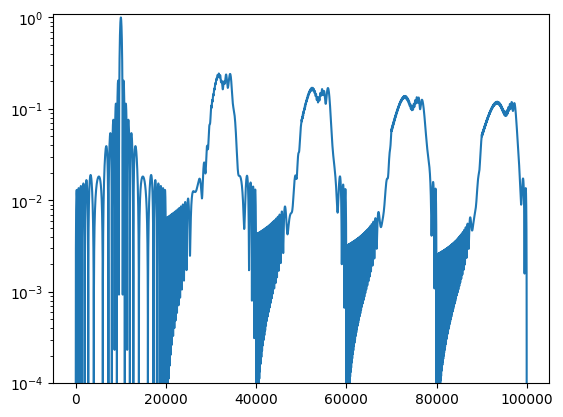

In [65]:
list_of_chirps = (
            chirp([0,1],nSamples,samplingFrequency),
            chirp([0,2],nSamples,samplingFrequency),
            chirp([0,3],nSamples,samplingFrequency),
            chirp([0,4],nSamples,samplingFrequency),
            chirp([0,5],nSamples,samplingFrequency)
        )
plt.plot(allAbsMFOutputs(chirp([0,1],nSamples,samplingFrequency),list_of_chirps));
plt.yscale("log")
plt.ylim(10**-4, 1.1);

# Real-Life Values

In [66]:
param_dict = {"Air Mode 1":[9750,1],"Air Mode 2":[9750,30],"Air Mode 3":[9750,14],"Air Mode 4":[9750,29],
               "Weather Mode 1":[9500,382],"Weather Mode 2":[9500,131],"Weather Mode 3":[9500,1000],
               "Weather Mode 4":[9500,375],"Weather Mode 5":[9500,300],"Marine Mode 1":[9410,400],
               "Marine Mode 2":[9410,111],"Marine Mode 3":[9410,440],"Marine Mode 4":[9410,500],
               "Marine Mode 5":[9410,139],"Marine Mode 6":[9410,50]}

In [67]:
samplingFrequency = 1200
nSamples = 10000

# Data Prep

In [68]:
chirp1 = allAbsMFOutputs(chirp([0,1],nSamples,samplingFrequency),list_of_chirps)
chirp2 = allAbsMFOutputs(chirp([0,2],nSamples,samplingFrequency),list_of_chirps)
chirp3 = allAbsMFOutputs(chirp([0,3],nSamples,samplingFrequency),list_of_chirps)
chirp4 = allAbsMFOutputs(chirp([0,4],nSamples,samplingFrequency),list_of_chirps)
chirp5 = allAbsMFOutputs(chirp([0,5],nSamples,samplingFrequency),list_of_chirps)

In [69]:
pd.DataFrame({1:chirp1,2:chirp2,3:chirp3,4:chirp4,5:chirp5}).to_csv('output.csv',index=False)

In [70]:
chirp_dataset = pd.read_csv('output.csv')

In [71]:
chirp_dataset

,1,2,3,4,5
0,0.000100,0.000100,0.000100,0.000100,0.000100
1,0.000200,0.000200,0.000200,0.000200,0.000200
2,0.000300,0.000300,0.000300,0.000300,0.000300
3,0.000400,0.000400,0.000400,0.000400,0.000400
4,0.000500,0.000500,0.000500,0.000500,0.000500
...,...,...,...,...,...
99990,0.000499,0.000496,0.000491,0.000485,0.000477
99991,0.000400,0.000398,0.000396,0.000392,0.000388
99992,0.000300,0.000299,0.000298,0.000297,0.000295
99993,0.000200,0.000200,0.000200,0.000199,0.000199


# Training Model

In [72]:
X = []
y = []
for i in chirp_dataset:
    X.append(list(chirp_dataset[i]))
    y += i

print("Training input shape: ", np.array(X).shape)


Training input shape:  (5, 99995)


In [73]:
clf = svm.SVC()
y

['1', '2', '3', '4', '5']

In [74]:
clf.fit(X,y)

SVC()

In [75]:
x_predict = np.array(chirp_dataset['2']).reshape(1,-1)
print(clf.predict(x_predict))

['2']


# Predicting with Noise 

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


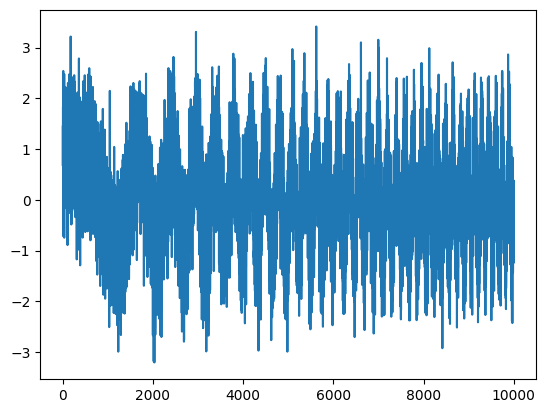

In [76]:
snr = 0 
whiteNoisePoints = complexWhiteNoise(nSamples)/(10**(snr/20))
p = chirp([0,1],nSamples,samplingFrequency) + whiteNoisePoints
plt.plot(p)

In [77]:
match_filter = allAbsMFOutputs(p,list_of_chirps)

In [78]:
x_predict = np.array(match_filter).reshape(1,-1)
clf.predict(x_predict)

array(['1'], dtype='<U1')

# Confusion Matrix 

In [79]:
snr = 10 
whiteNoisePoints = complexWhiteNoise(nSamples)/(10**(snr/20))

In [80]:
X_test = [chirp([0,1],nSamples,samplingFrequency) + whiteNoisePoints,chirp([0,2],nSamples,samplingFrequency) + whiteNoisePoints,
         chirp([0,3],nSamples,samplingFrequency) + whiteNoisePoints,chirp([0,4],nSamples,samplingFrequency) + whiteNoisePoints,
         chirp([0,5],nSamples,samplingFrequency) + whiteNoisePoints]
X_test = [allAbsMFOutputs(i,list_of_chirps) for i in X_test]

In [81]:
y_test = ['1','2','3','4','5']

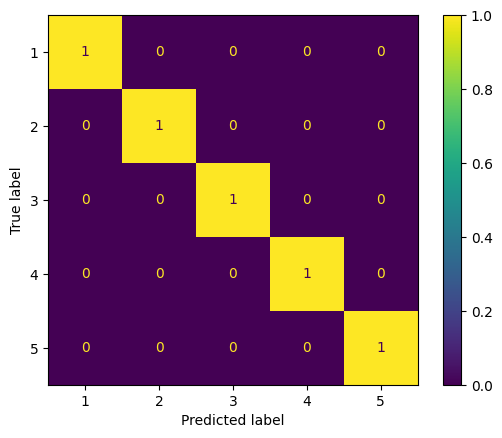

In [82]:
ConfusionMatrixDisplay.from_estimator(clf,X_test,y_test)
# ConfusionMatrixDisplay.from_predictions(clf,X_test,y_test)

# Training Model with White Noise

In [83]:
SNR = [10,0,-5,-10,-15,-20]

In [84]:
model_training = True
if model_training:
    X_train = []
    y_train = []
    for i in range(1,6):
        for snr in SNR:
            for _ in range(50):
                whiteNoisePoints = complexWhiteNoise(nSamples)/(10**(snr/20))
                noisy_chirp = chirp([0,i],nSamples,samplingFrequency)+whiteNoisePoints
                X_train.append(allAbsMFOutputs(noisy_chirp,list_of_chirps))
                y_train.append(i)
    clf.fit(X_train,y_train)
else:
    clf = pickle.load(open('CHIRP_Model.pkl','rb'))

# Saving Model

In [85]:
pkl_filename = "CHIRP_Model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf, file)

# Testing Model

In [86]:
def generate_test(snr:int)->(list,list):
    X_test = []
    y_test = []
    for i in range(1,6):
        for _ in range(10):
            whiteNoisePoints = complexWhiteNoise(nSamples)/(10**(snr/20))
            noisy_chirp = chirp([0,i],nSamples,samplingFrequency)+whiteNoisePoints
            X_test.append(allAbsMFOutputs(noisy_chirp,list_of_chirps))
            y_test.append(i)
    return (X_test,y_test)

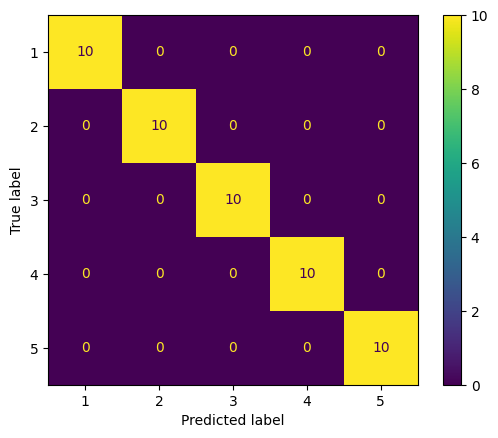

In [87]:
snr_10_tests = generate_test(10)
ConfusionMatrixDisplay.from_estimator(clf,snr_10_tests[0],snr_10_tests[1])

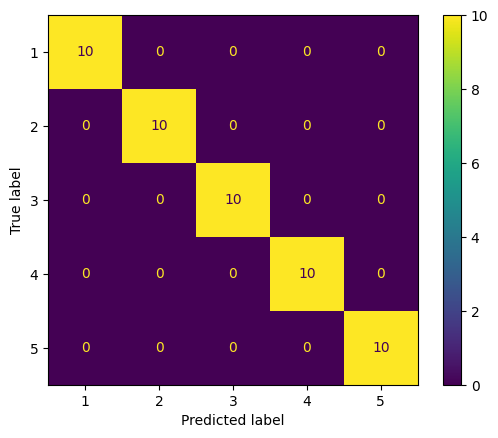

In [88]:
snr_0_tests = generate_test(0)
ConfusionMatrixDisplay.from_estimator(clf,snr_0_tests[0],snr_0_tests[1])

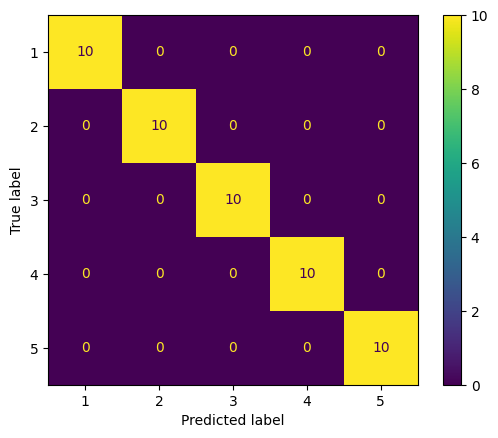

In [89]:
snr_5_tests = generate_test(-5)
ConfusionMatrixDisplay.from_estimator(clf,snr_5_tests[0],snr_5_tests[1])

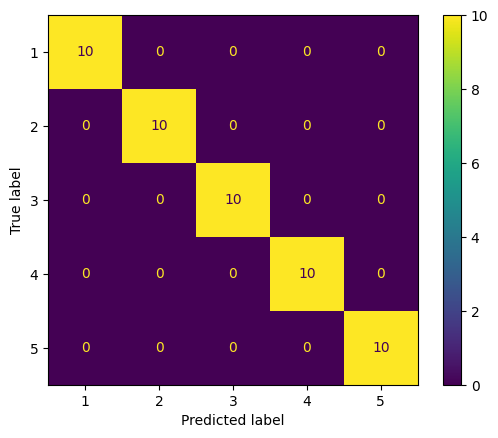

In [90]:
snr_10_tests = generate_test(-10)
ConfusionMatrixDisplay.from_estimator(clf,snr_10_tests[0],snr_10_tests[1])

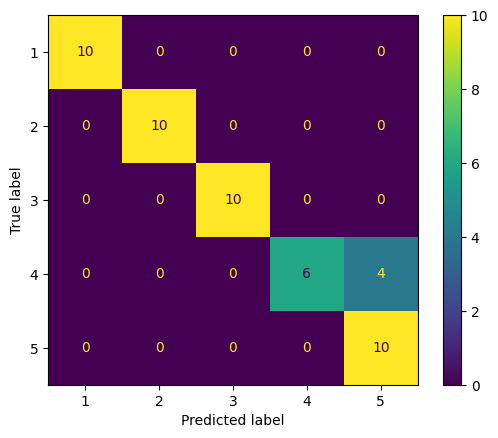

In [91]:
snr_15_tests = generate_test(-15)
ConfusionMatrixDisplay.from_estimator(clf,snr_15_tests[0],snr_15_tests[1])

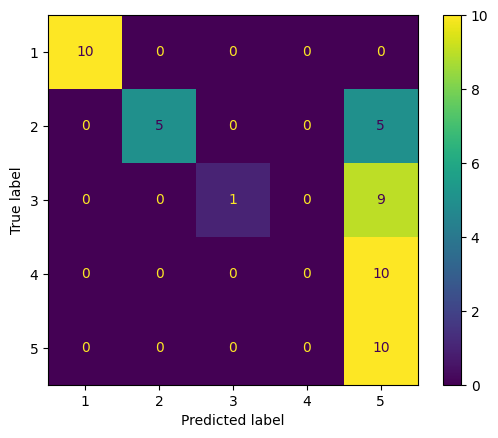

In [92]:
snr_20_tests = generate_test(-20)
ConfusionMatrixDisplay.from_estimator(clf,snr_20_tests[0],snr_20_tests[1])